In [1]:
# standard libraries
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

# system libraries
import os
import sys
from pathlib import Path
# Add the src directory to the path in order to import config
current_directory = Path.cwd()
src_path = current_directory.parent / "src"
sys.path.insert(0, str(src_path))

# project files
import config
import load_option_data_01 as l1
import filter_option_data_01 as f1
import wrds
import bsm_pricer as bsm

# environment variables
WRDS_USERNAME = Path(config.WRDS_USERNAME)
DATA_DIR = Path(config.DATA_DIR)
OUTPUT_DIR = Path(config.OUTPUT_DIR)


# Helper functions

In [2]:
def fit_and_store_curve(group):
    """
    Fit a quadratic curve to the given group of data points and store the fitted values.

    Args:
        group (pandas.DataFrame): The group of data points to fit the curve to.

    Returns:
        pandas.DataFrame: The group of data points with the fitted values stored in the 'fitted_iv' column.
    """
    # Drop rows with NaN in 'moneyness' or 'log_iv'
    group = group.dropna(subset=['mnyns', 'log_iv'])
    if len(group) < 3:  # Need at least 3 points to fit a quadratic curve
        return group
    try:
        # Fit the quadratic curve
        coefficients = np.polyfit(group['mnyns'], group['log_iv'], 2)
        # Calculate fitted values
        group['fitted_iv'] = np.polyval(coefficients, group['mnyns'])
    except np.RankWarning:
        print("Polyfit may be poorly conditioned")
    return group


In [3]:
def calc_relative_distance(series1, series2, method='percent'):
    """
    Calculate the relative distance between the implied volatility and the fitted implied volatility.
    
    Parameters:
        method (str): The method to calculate the relative distance. Options are 'percent', 'manhattan', or 'euclidean'.
        
    Returns:
        numpy.ndarray: The relative distance calculated based on the specified method.
        
    Raises:
        ValueError: If the method is not one of 'percent', 'manhattan', or 'euclidean'.
    """
    
    if method == 'percent':
        result = (series1 - series2) / series2 * 100
    elif method == 'manhattan':
        result = abs(series1 - series2)
    elif method == 'euclidean':
        result = np.sqrt((series1 - series2)**2)
    else:
        raise ValueError("Method must be 'percent', 'manhattan', or 'euclidean'")
    
    result = np.where(np.isinf(result), np.nan, result)
    
    return result
    

In [4]:
def mark_outliers(row, std_devs, outlier_threshold):
    """
    Determines if a data point is an outlier based on its moneyness_bin and relative distance from the fitted curve.
    
    Args:
        row (pandas.Series): A row of data containing the moneyness_bin and rel_distance columns.
        std_devs (pandas.DataFrame): A DataFrame containing the standard deviations for each moneyness_bin.
    
    Returns:
        bool: True if the data point is an outlier, False otherwise.
    """
    
    # Attempt to retrieve the standard deviation for the row's moneyness_bin
    std_dev_row = std_devs.loc[std_devs['mnyns_bin'] == row['mnyns_bin'], 'std_dev']
    
    # Check if std_dev_row is empty (i.e., no matching moneyness_bin was found)
    if not std_dev_row.empty:
        std_dev = std_dev_row.values[0]
        # Calculate how many std_devs away from the fitted curve the IV is
        if abs(row['rel_distance']) > outlier_threshold * std_dev:  # Adjust this threshold as needed
            return True
    else:
        # Handle the case where no matching moneyness_bin was found
        return False
    return False


In [5]:
def build_put_call_pairs(call_options, put_options):
    """
    Builds pairs of call and put options based on the same date, expiration date, and moneyness.

    Args:
        call_options (DataFrame): DataFrame containing call options data.
        put_options (DataFrame): DataFrame containing put options data.

    Returns:
        tuple of (matching_calls: pd.DataFrame, matching_puts: pd.DataFrame)
    """
    call_options.set_index(['date', 'exdate', 'mnyns'], inplace=True)
    put_options.set_index(['date', 'exdate', 'mnyns'], inplace=True)
    
    # get common indices
    common_index = call_options.index.intersection(put_options.index)

    # Extract the matching entries
    matching_calls = call_options.loc[common_index]
    matching_puts = put_options.loc[common_index]
    
    result = (matching_calls, matching_puts)

    return result

In [6]:
def test_price_strike_match(matching_calls_puts):
    return (np.allclose(matching_calls_puts['strike_price_C'], matching_calls_puts['strike_price_P'])) and (np.allclose(matching_calls_puts['sec_price_C'], matching_calls_puts['sec_price_P']))# and (np.allclose(matching_calls_puts['tb_m3_C'], matching_calls_puts['tb_m3_P']))

In [7]:
def calc_implied_interest_rate(matched_options):
    """
    Calculates the implied interest rate based on the given matched options data.

    Parameters:
    matched_options (DataFrame): DataFrame containing the matched options data.

    Returns:
    DataFrame: DataFrame with an additional column 'pc_parity_int_rate' representing the implied interest rate.
    
    Raises:
    ValueError: If there is a mismatch between the price and strike price of the options.
    """
    
    # underlying price
    if test_price_strike_match(matched_options):
        print(">> Underlying prices, strike prices of put and call options match exactly.")
        S = matched_options['sec_price_C']
        K = matched_options['strike_price_C']  
        
        # 1/T = 1/time to expiration in years
        T_inv = np.power((matched_options.reset_index()['exdate']-matched_options.reset_index()['date'])/datetime.timedelta(days=365), -1)
        T_inv.index=matched_options.index
        T_inv
        
        C_mid = matched_options['mid_price_C']
        P_mid = matched_options['mid_price_P']
        # implied interest rate
        matched_options['pc_parity_int_rate'] = np.log((S-C_mid+P_mid)/K) * T_inv
        return matched_options
    else:
        raise ValueError("Price and strike price mismatch")

In [8]:
def pcp_filter_sensitivity(matched_options, int_rate_rel_distance_func, outlier_threshold):
    """
    Run a sensitivity analysis on the put-call parity filter, using different methods for relative distance and different standard deviation outlier thresholds.cx

    Parameters:
    matched_options (DataFrame): DataFrame containing the matched options data.
    int_rate_rel_distance_func (str): Method to calculate relative distance for interest rate.
    outlier_threshold (float): Threshold for flagging outliers.

    Returns:
    dict: A dictionary containing the number of deleted and remaining options after filtering.
    """
    matched_options['rel_distance_int_rate'] = calc_relative_distance(matched_options['pc_parity_int_rate'], matched_options['daily_median_rate'], method=int_rate_rel_distance_func)
    # fill 3905 nans...
    matched_options['rel_distance_int_rate'] = matched_options['rel_distance_int_rate'].fillna(0.0)

    # calculate the standard deviation of the relative distances
    stdev_int_rate_rel_distance = matched_options['rel_distance_int_rate'].std()

    # flag outliers based on the threshold
    matched_options['is_outlier_int_rate'] = matched_options['rel_distance_int_rate'].abs() > outlier_threshold * stdev_int_rate_rel_distance

    # filter out the outliers
    l3_filtered_options = matched_options[~matched_options['is_outlier_int_rate']]

    # make the dataframe long-form to compare to the level 2 data
    _calls = l3_filtered_options.filter(like='_C').rename(columns=lambda x: x.replace('_C', ''))
    _puts = l3_filtered_options.filter(like='_P').rename(columns=lambda x: x.replace('_P', ''))
    l3_filtered_options = pd.concat((_calls, _puts), axis=0)

    # update the final results for this combination of relative distance method and outlier threshold
    return l3_filtered_options


In [9]:
def iv_filter_sensitivity(l2_data, iv_distance_method, iv_outlier_threshold):
    """
    Filter out outliers based on the sensitivity of the implied volatility (IV) data.

    Args:
        l2_data (DataFrame): DataFrame containing the IV data.
        iv_distance_method (str): Method used to calculate the relative distance between observed and fitted IV.
        iv_outlier_threshold (float): Threshold for flagging outliers based on the standard deviation of relative distances.

    Returns:
        DataFrame: Filtered DataFrame with outliers removed.

    """
    l2_data['rel_distance_iv'] = calc_relative_distance(l2_data['log_iv'], l2_data['fitted_iv'], method=iv_distance_method)

    # Define moneyness bins
    bins = np.arange(0.8, 1.21, 0.05)
    l2_data['mnyns_bin'] = pd.cut(l2_data['mnyns'], bins=bins)

    # Compute standard deviation of relative distances within each moneyness bin
    std_devs = l2_data.groupby('mnyns_bin')['rel_distance_iv'].std().reset_index(name='std_dev')
    std_devs
    l2_data
    l2_data['stdev_iv_mnyns_bin'] = l2_data['mnyns_bin'].map(std_devs.set_index('mnyns_bin')['std_dev'])
    l2_data['stdev_iv_mnyns_bin'].apply(lambda x: x*iv_outlier_threshold).astype(float)
    # flag outliers based on the threshold
    l2_data['is_outlier_iv'] = l2_data['rel_distance_iv'].abs() > l2_data['stdev_iv_mnyns_bin'].apply(lambda x: x*iv_outlier_threshold).astype(float)

    # filter out the outliers
    l3_data_iv_only = l2_data[~l2_data['is_outlier_iv']]
    
    # update the final results for this combination of relative distance method and outlier threshold
    return l3_data_iv_only


# Table B1 Results for Level 3 Filter (per paper)


In [10]:
check_results = pd.DataFrame(index=pd.MultiIndex.from_product([['Level 3 filters'], ['IV filter', 'Put-call parity filter', 'All']]),
                             columns=pd.MultiIndex.from_product([['Berkeley', 'OptionMetrics'], ['Deleted', 'Remaining']]))
check_results.loc[['Level 3 filters'], ['Berkeley', 'OptionMetrics']] = [[10865, np.nan, 67850, np.nan], [10298, np.nan,46138, np.nan], [np.nan, 173500,np.nan, 962784]]

check_results


Berkeley           OptionMetrics  \
                                        Deleted Remaining       Deleted   
Level 3 filters IV filter                 10865       NaN         67850   
                Put-call parity filter    10298       NaN         46138   
                All                         NaN    173500           NaN   

                                                  
                                       Remaining  
Level 3 filters IV filter                    NaN  
                Put-call parity filter       NaN  
                All                       962784

In [11]:
print(check_results.to_string())

                                       Berkeley           OptionMetrics          
                                        Deleted Remaining       Deleted Remaining
Level 3 filters IV filter                 10865       NaN         67850       NaN
                Put-call parity filter    10298       NaN         46138       NaN
                All                         NaN    173500           NaN    962784


# Implementation of Level 3 Filters: IV Filter

*Methodology*

The process for construction of the IV filter is as follows:

<ol>

<li> The IV filter removes volatility outliers to reduce the prevalence of apparent butterfly arbitrage. This involves dropping calls and puts that have the same expiration date and strike price, but have anomalous prices due to extreme implied volatility values. 

<li> For each *date* and *maturity*, we fit a quadratic curve to the implied volatility of puts and calls (separately) through the observed log implied volatilities

</ol>

In [12]:
# read in L2 filtered data
l2_data = pd.read_parquet(DATA_DIR / "pulled/data_199601_201201_L2filter.parquet", columns=['secid', 'date', 'exdate', 'cp_flag', 'mnyns', 'impl_volatility', 'tb_m3', 'best_bid', 'best_offer', 'strike_price', 'contract_size', 'sec_price'])
l2_data
# calc log IV 
l2_data['log_iv'] = np.log(l2_data['impl_volatility'])
l2_data

,secid,date,exdate,cp_flag,mnyns,impl_volatility,tb_m3,best_bid,best_offer,strike_price,contract_size,sec_price,log_iv
0,108105.0,1996-01-04,1996-02-17,C,0.922778,NaN,0.0504,48.250,49.250,570.0,100.0,617.70,NaN
1,108105.0,1996-01-04,1996-06-22,C,0.963251,0.125173,0.0504,38.500,39.500,595.0,100.0,617.70,-2.078058
2,108105.0,1996-01-04,1996-03-16,C,1.011818,0.103697,0.0504,9.125,9.875,625.0,100.0,617.70,-2.266282
3,108105.0,1996-01-04,1996-03-16,C,0.938967,0.110537,0.0504,41.500,42.500,580.0,100.0,617.70,-2.202405
4,108105.0,1996-01-04,1996-03-16,C,0.906589,NaN,0.0504,59.750,60.750,560.0,100.0,617.70,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1274099,108105.0,2012-01-31,2012-06-29,P,1.085789,0.158748,0.0006,135.300,138.900,1425.0,100.0,1312.41,-1.840437
1274100,108105.0,2012-01-31,2012-06-29,P,1.104838,0.150582,0.0006,154.900,158.400,1450.0,100.0,1312.41,-1.893247
1274101,108105.0,2012-01-31,2012-06-29,P,1.123887,0.144663,0.0006,176.400,179.800,1475.0,100.0,1312.41,-1.933348
1274102,108105.0,2012-01-31,2012-06-29,P,1.142936,0.137213,0.0006,198.700,202.400,1500.0,100.0,1312.41,-1.986221


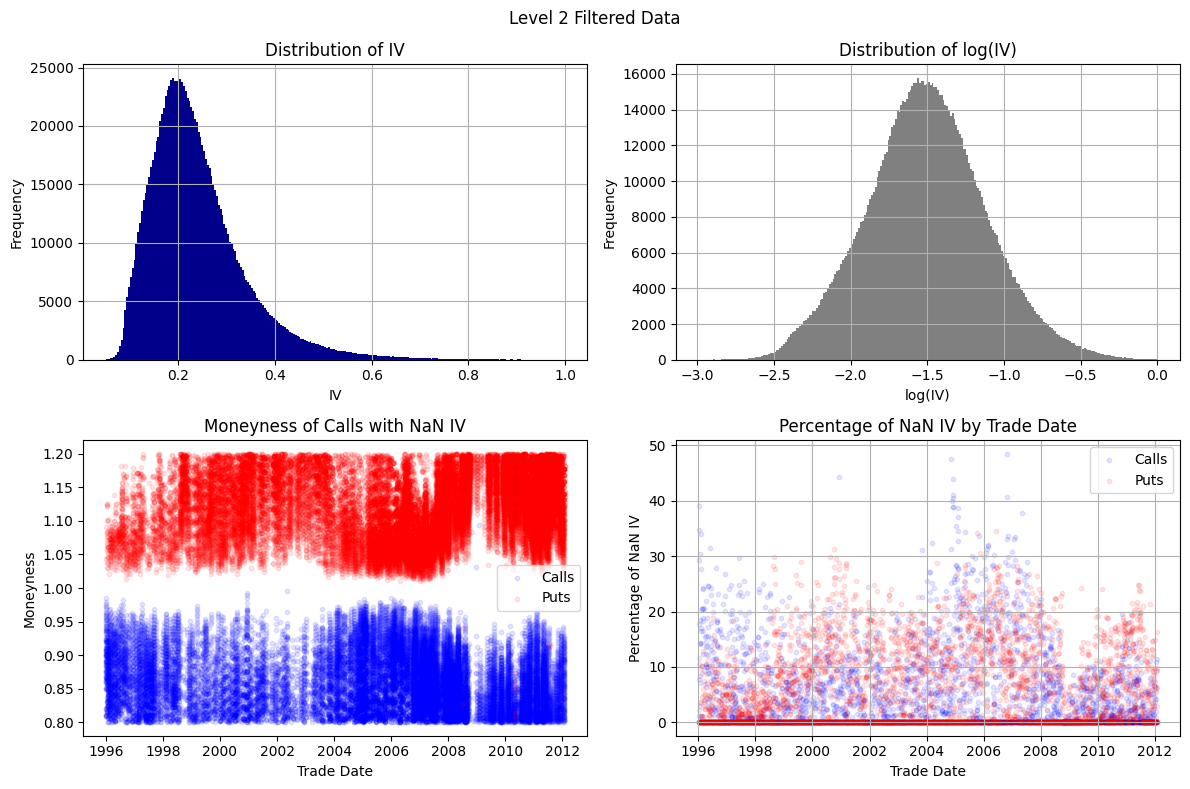

In [13]:
fig, ax = plt.subplots(2,2, figsize=(12,8))

ax[0,0].hist(l2_data['impl_volatility'], bins=250, color='darkblue')
ax[0,0].set_xlabel('IV')
ax[0,0].set_ylabel('Frequency')
ax[0,0].set_title('Distribution of IV')
ax[0,0].grid()

ax[0,1].hist(l2_data['log_iv'], bins=250, color='grey')
ax[0,1].set_xlabel('log(IV)')
ax[0,1].set_ylabel('Frequency')
ax[0,1].set_title('Distribution of log(IV)')
ax[0,1].grid()

# options with nan implied volatility
# calls only
nan_iv = l2_data[(l2_data['cp_flag'] == 'C') & (l2_data['impl_volatility'].isna())]
ax[1,0].scatter(x=nan_iv['date'], y=nan_iv['mnyns'], color='blue', alpha=0.1, s=10, label='Calls')

# puts only
nan_iv = l2_data[(l2_data['cp_flag'] == 'P') & (l2_data['impl_volatility'].isna())]
ax[1,0].scatter(x=nan_iv['date'], y=nan_iv['mnyns'], color='red', alpha=0.1, s=10, label='Puts')

ax[1,0].set_xlabel('Trade Date')
ax[1,0].set_ylabel('Moneyness')
ax[1,0].set_title('Moneyness of Calls with NaN IV')
ax[1,0].grid()
ax[1,0].legend()
ax[1,0].grid()


# percentage of NaN IV
nan_percentage = l2_data.groupby(['date', 'cp_flag'])['impl_volatility'].apply(lambda x: (x.isna().sum() / len(x))*100)

# calls only
nan_percentage_calls = nan_percentage[nan_percentage.index.get_level_values(1)=='C']
ax[1,1].scatter(x=nan_percentage_calls.index.get_level_values(0), y=nan_percentage_calls.values, color='blue', alpha = 0.1, s=10, label='Calls')

# puts only
nan_percentage_puts = nan_percentage[nan_percentage.index.get_level_values(1)=='P']
ax[1,1].scatter(x=nan_percentage_puts.index.get_level_values(0), y=nan_percentage_puts.values, color='red', alpha = 0.1, s=10, label='Puts')

ax[1,1].set_xlabel('Trade Date')
ax[1,1].set_ylabel('Percentage of NaN IV')
ax[1,1].set_title('Percentage of NaN IV by Trade Date')
ax[1,1].legend()
ax[1,1].grid()

# Hide ax[1,2]
#ax[1,2].axis('off')

plt.suptitle('Level 2 Filtered Data')
plt.tight_layout()
plt.show()

# Noting NaN IV Options in the Level 2 Filtered Data
We note that after the Level 2 filters, there are still several NaNs in the IVs of the remaining options. On any given trade date, the number of NaN IV options reach as high as 50% of the options on a given date. It is also interesting to note that the NaN IVs typically are in options that not near-the-money. However, as we see below, the total number of NaN IV options over the entire dataseries is 3.76% for calls, and 5.67% for puts.

In [14]:
nan_iv_calls = l2_data[(l2_data['cp_flag'] == 'C') & (l2_data['impl_volatility'].isna())]
nan_iv_puts = l2_data[(l2_data['cp_flag'] == 'P') & (l2_data['impl_volatility'].isna())]
nan_iv_summary = pd.DataFrame(index=['Calls', 'Puts'], columns = ['NaN IV Records', 'Total Records', '% NaN IV'])
nan_iv_summary.loc['Calls'] = [len(nan_iv_calls), len(l2_data[l2_data['cp_flag'] == 'C']), len(nan_iv_calls)/len(l2_data[l2_data['cp_flag'] == 'C'])*100]
nan_iv_summary.loc['Puts'] = [len(nan_iv_puts), len(l2_data[l2_data['cp_flag'] == 'P']), len(nan_iv_puts)/len(l2_data[l2_data['cp_flag'] == 'P'])*100]
nan_iv_summary.style.format({'NaN IV Records': '{:,.0f}',
                             'Total Records': '{:,.0f}',
                             '% NaN IV': '{:.2f}%'}).set_caption('Summary of NaN IV Records in Level 2 Filtered Data')


,NaN IV Records,Total Records,% NaN IV
Calls,"23,471","624,596",3.76%
Puts,"36,848","649,508",5.67%


# Removing IV Outliers

The first step in the Level 3 filters is to remove IV outliers from the dataset. To do this, we fit quadratic curves to each set of calls and puts, grouped by date (`date`) and maturity (`exdate`).

In [15]:
# Apply the quadratic curve fitting function to the data
l2_data = l2_data.groupby(['date', 'exdate', 'cp_flag']).apply(fit_and_store_curve)

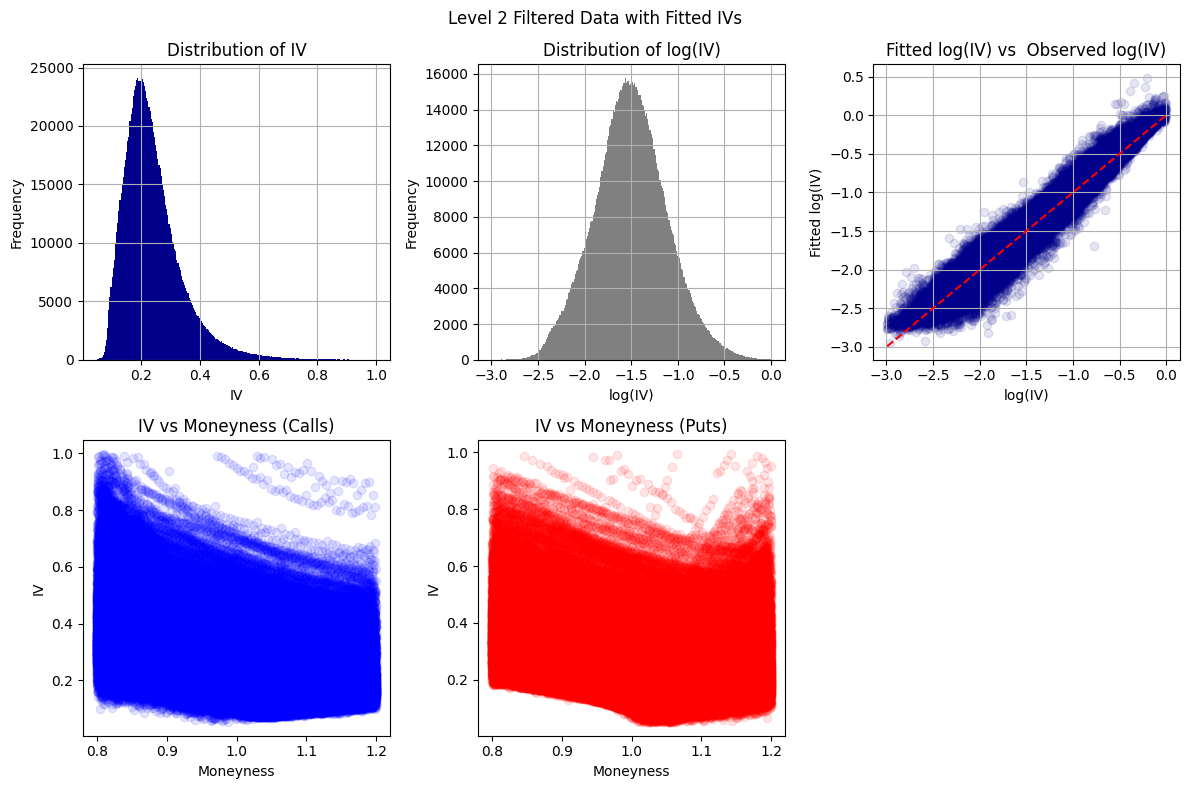

In [16]:
fig, ax = plt.subplots(2,3, figsize=(12,8))

ax[0,0].hist(l2_data['impl_volatility'], bins=250, color='darkblue')
ax[0,0].set_xlabel('IV')
ax[0,0].set_ylabel('Frequency')
ax[0,0].set_title('Distribution of IV')
ax[0,0].grid()

ax[0,1].hist(l2_data['log_iv'], bins=250, color='grey')
ax[0,1].set_xlabel('log(IV)')
ax[0,1].set_ylabel('Frequency')
ax[0,1].set_title('Distribution of log(IV)')
ax[0,1].grid()

# Scatter plot of IV vs fitted IV
ax[0,2].scatter(x=l2_data['log_iv'], y=l2_data['fitted_iv'], color='darkblue', alpha=0.1)
ax[0,2].set_xlabel('log(IV)')
ax[0,2].set_ylabel('Fitted log(IV)')
ax[0,2].set_title('Fitted log(IV) vs  Observed log(IV)')
# Add 45-deg line
ax[0,2].plot([min(l2_data['log_iv']), max(l2_data['log_iv'])], [min(l2_data['log_iv']), max(l2_data['log_iv'])], color='red', linestyle='--')
ax[0,2].grid()


ax[1,0].scatter(x=l2_data.xs('C', level='cp_flag')['mnyns'], y=np.exp(l2_data.xs('C', level='cp_flag')['log_iv']), color='blue', alpha=0.1, label='IV')
ax[1,0].set_xlabel('Moneyness')
ax[1,0].set_ylabel('IV')
ax[1,0].set_title('IV vs Moneyness (Calls)')

ax[1,1].scatter(x=l2_data.xs('P', level='cp_flag')['mnyns'], y=np.exp(l2_data.xs('P', level='cp_flag')['log_iv']), color='red', alpha=0.1, label='IV')
ax[1,1].set_xlabel('Moneyness')
ax[1,1].set_ylabel('IV')
ax[1,1].set_title('IV vs Moneyness (Puts)')

# Hide ax[1,2]
ax[1,2].axis('off')

plt.suptitle('Level 2 Filtered Data with Fitted IVs')
plt.tight_layout()
plt.show()

In [19]:
l3_data_iv_only = iv_filter_sensitivity(l2_data, 'percent', 2.0)
# convert mnyns_bin to string to save
l3_data_iv_only['mnyns_bin'] = l3_data_iv_only['mnyns_bin'].astype(str)
l3_data_iv_only.to_parquet(DATA_DIR / "intermediate/data_199601_201201_L3filterIVonly.parquet")

In [20]:
final_result = check_results.loc[:,'OptionMetrics'].copy(deep=True)
final_result.loc[('Level 3 filters', 'IV filter'), 'Deleted'] = len(l2_data)-len(l3_data_iv_only)

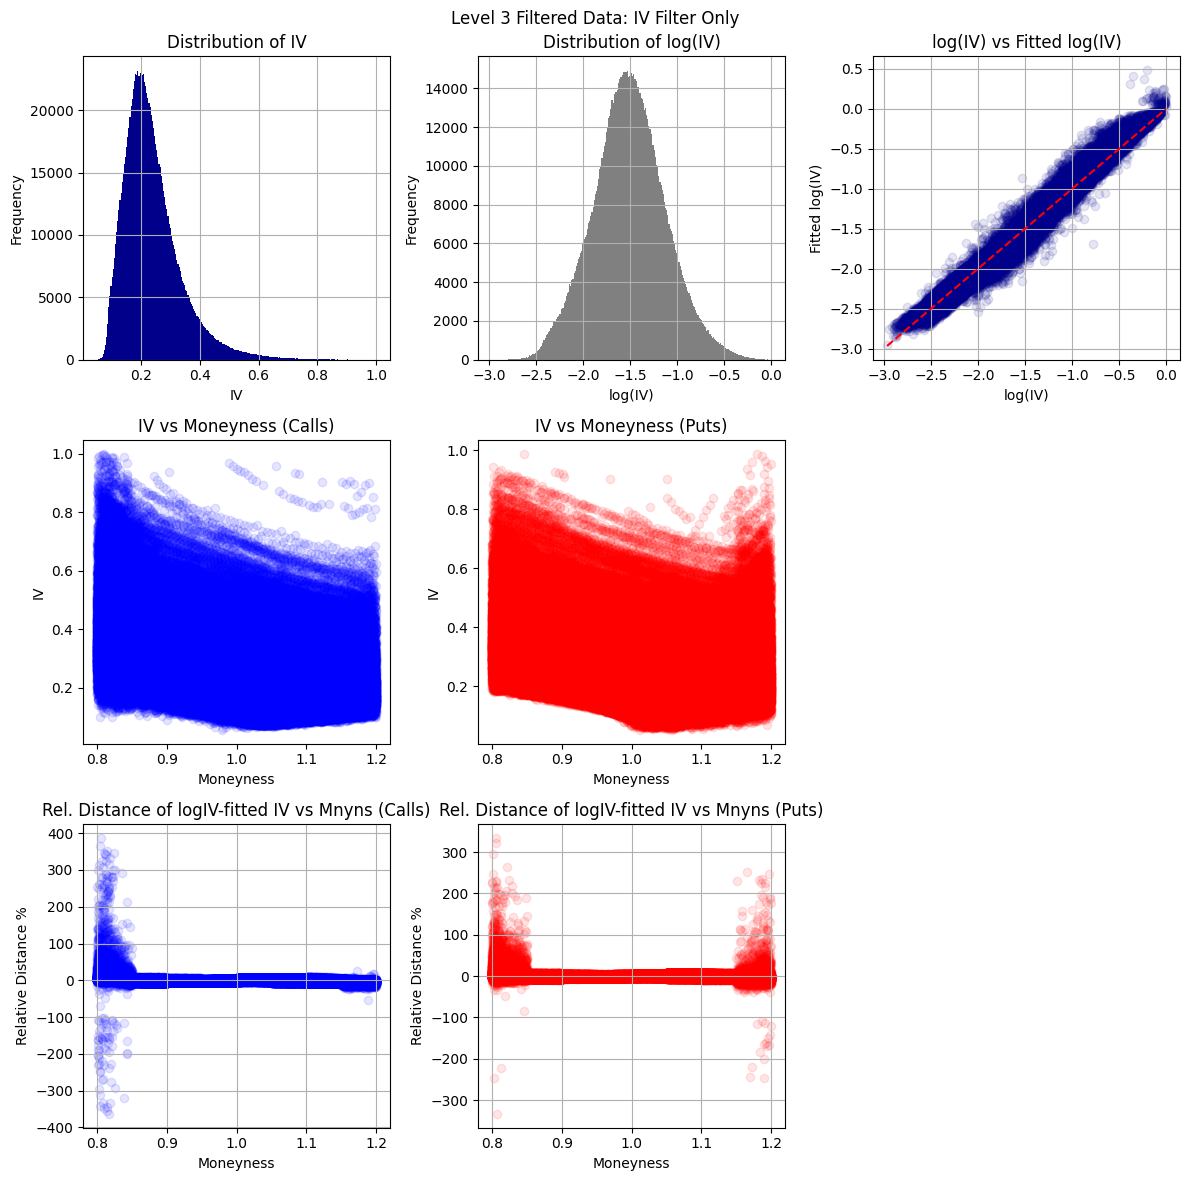

In [21]:
fig, ax = plt.subplots(3,3, figsize=(12,12))

ax[0,0].hist(l3_data_iv_only['impl_volatility'], bins=250, color='darkblue')
ax[0,0].set_xlabel('IV')
ax[0,0].set_ylabel('Frequency')
ax[0,0].set_title('Distribution of IV')
ax[0,0].grid()

ax[0,1].hist(l3_data_iv_only['log_iv'], bins=250, color='grey')
ax[0,1].set_xlabel('log(IV)')
ax[0,1].set_ylabel('Frequency')
ax[0,1].set_title('Distribution of log(IV)')
ax[0,1].grid()

# Scatter plot with x=log_iv and y=fitted_iv
ax[0,2].scatter(x=l3_data_iv_only['log_iv'], y=l3_data_iv_only['fitted_iv'], color='darkblue', alpha=0.1)
ax[0,2].set_xlabel('log(IV)')
ax[0,2].set_ylabel('Fitted log(IV)')
ax[0,2].set_title('log(IV) vs Fitted log(IV)')
# Add a 45-degree line
ax[0,2].plot([min(l3_data_iv_only['log_iv']), max(l3_data_iv_only['log_iv'])], [min(l3_data_iv_only['log_iv']), max(l3_data_iv_only['log_iv'])], color='red', linestyle='--')
ax[0,2].grid()


ax[1,0].scatter(x=l3_data_iv_only.xs('C', level='cp_flag')['mnyns'], y=np.exp(l3_data_iv_only.xs('C', level='cp_flag')['log_iv']), color='blue', alpha=0.1, label='IV')
ax[1,0].set_xlabel('Moneyness')
ax[1,0].set_ylabel('IV')
ax[1,0].set_title('IV vs Moneyness (Calls)')

ax[1,1].scatter(x=l3_data_iv_only.xs('P', level='cp_flag')['mnyns'], y=np.exp(l3_data_iv_only.xs('P', level='cp_flag')['log_iv']), color='red', alpha=0.1, label='IV')
ax[1,1].set_xlabel('Moneyness')
ax[1,1].set_ylabel('IV')
ax[1,1].set_title('IV vs Moneyness (Puts)')


ax[2,0].scatter(x=l3_data_iv_only.xs('C', level='cp_flag')['mnyns'], y=l3_data_iv_only.xs('C', level='cp_flag')['rel_distance_iv'], color='blue', alpha=0.1, label='Calls')
ax[2,0].set_xlabel('Moneyness')
ax[2,0].set_ylabel('Relative Distance %')
ax[2,0].set_title('Rel. Distance of logIV-fitted IV vs Mnyns (Calls)')
ax[2,0].grid()

ax[2,1].scatter(x=l3_data_iv_only.xs('P', level='cp_flag')['mnyns'], y=l3_data_iv_only.xs('P', level='cp_flag')['rel_distance_iv'], color='red', alpha=0.1, label='Puts')
ax[2,1].set_xlabel('Moneyness')
ax[2,1].set_ylabel('Relative Distance %')
ax[2,1].set_title('Rel. Distance of logIV-fitted IV vs Mnyns (Puts)')
ax[2,1].grid()

# hide unused subplots
ax[1,2].axis('off')
ax[2,2].axis('off')

plt.suptitle('Level 3 Filtered Data: IV Filter Only')
plt.tight_layout()
plt.show()

In [22]:
ntm_rel_dist = l3_data_iv_only[(l3_data_iv_only['mnyns'] < 1.1) & (l3_data_iv_only['mnyns'] > 0.9)].describe()['rel_distance_iv'].to_frame().rename(columns={'rel_distance_iv': 'Near-The-Money'})
fftm_rel_dist = l3_data_iv_only[(l3_data_iv_only['mnyns'] > 1.1) | (l3_data_iv_only['mnyns'] < 0.9)].describe()['rel_distance_iv'].to_frame().rename(columns={'rel_distance_iv': 'Far-From-The-Money Options'})
rel_dist_stats = pd.concat([ntm_rel_dist, fftm_rel_dist], axis=1)
display(rel_dist_stats.style.format('{:,.2f}').set_caption('Relative Distance Stats'))

,Near-The-Money,Far-From-The-Money Options
count,"737,608.00","409,800.00"
mean,-0.01,0.50
min,-7.50,-363.17
25%,-1.01,-1.16
50%,-0.03,-0.01
75%,0.90,1.09
max,7.50,386.61
std,2.05,7.95


We note that the relative distance estimate using the "percent" approach with a 2-standard deviation outlier cutoff threshold is nowhere near what the paper authors indicate (2% near the money, and 3.5% far from the money), as opposed to *-1%* near the money, and *50%* far from the money. Later in this analysis, we will present a sensitivity of the number of options deleted from the dataset with different approaches to distance and different thresholds for the outlier standard deviation cutoff. 

# Level 3 filter: Put-Call Parity

*Methodology*

The process for construction of the Put-Call Parity filter is as follows:

<ol>

<li> The puts and calls need to be matched up based on trading date, expiry date, and option type.

<li> We then calculate the put-call parity implied interest rate, and filter out outliers based on the standard deviation of the relative distance between the PCP implied interest rate, and the calculated daily median 3-month T-bill rate from the pulled data. 

</ol>

In [23]:
l3_data = l3_data_iv_only.copy(deep=True)

# Bid-Ask Midpoint Price and Matching Put-Call Pairs
- Next we calculate the bid-ask midpoint for each option in the dataset, and match put-call pairs. To do this, we need to ensure that for each call option, there's a corresponding put option with the same *strike price* and *expiration date*. 

In [24]:
# calculate bid-ask midpoint
l3_data['mid_price'] = (l3_data['best_bid'] + l3_data['best_offer']) / 2
# extract all the call options
call_options = l3_data.xs('C', level='cp_flag')
call_options
# extract all the put options
put_options = l3_data.xs('P', level='cp_flag')
put_options
matching_calls, matching_puts = build_put_call_pairs(call_options.reset_index(drop=True), put_options.reset_index(drop=True))

# Put-Call Parity Implied Interest Rate
- We now calculate the put-call parity implied interest rate, which can be achieved using: 
$$C-P=S-Ke^{rT}$$
$$e^{rT}=\frac{(S-C+P)}{K}$$
$$r=\frac{1}{T}\cdot log(\frac{S-C+P}{K})$$

In [25]:
# match the puts and calls
matched_options = pd.merge(matching_calls, matching_puts, on=['date', 'exdate', 'mnyns'], suffixes=('_C', '_P'))
# calculate the PCP implied interest rate 
matched_options = calc_implied_interest_rate(matched_options)
matched_options[matched_options['tb_m3_C'].eq(matched_options['tb_m3_P']) == False][['tb_m3_C', 'tb_m3_P']].isna().sum()

# Calculate the daily median implied interest rate from the T-Bill data (same for calls and puts on a given day)
daily_median_int_rate = matched_options.groupby('date')['tb_m3_C'].median().reset_index(name='daily_median_rate')
matched_options = matched_options.join(daily_median_int_rate.set_index('date'), on='date')
matched_options

>> Underlying prices, strike prices of put and call options match exactly.


secid_C cp_flag_C  impl_volatility_C  \
date       exdate     mnyns                                             
1996-01-04 1996-01-20 1.019913  108105.0         C           0.104694   
                      1.028007  108105.0         C           0.108615   
                      0.987534  108105.0         C           0.100806   
           1996-02-17 1.036102  108105.0         C           0.106798   
                      0.971345  108105.0         C           0.098828   
...                                  ...       ...                ...   
2012-01-31 2012-06-29 1.085789  108105.0         C           0.158147   
                      1.104838  108105.0         C           0.152500   
                      1.123887  108105.0         C           0.147193   
                      1.142936  108105.0         C           0.143243   
                      1.181033  108105.0         C           0.138542   

                                tb_m3_C  best_bid_C  best_offer_C  \
date       exdate     mnyns                                         
1996-01-04 1996-01-20 1.019913   0.0504      1.1875         1.375   
                      1.028007   0.0504      0.6250         0.750   
                      0.987534   0.0504     10.0000        10.375   
           1996-02-17 1.036102   0.0504      2.2500         2.500   
                      0.971345   0.0504     21.1250        22.125   
...                                 ...         ...           ...   
2012-01-31 2012-06-29 1.085789   0.0006     13.1000        15.000   
                      1.104838   0.0006      8.1000        10.200   
                      1.123887   0.0006      4.8000         6.500   
                      1.142936   0.0006      2.8000         4.000   
                      1.181033   0.0006      0.9500         1.400   

                                strike_price_C  contract_size_C  sec_price_C  \
date       exdate     mnyns                                                    
1996-01-04 1996-01-20 1.019913           630.0            100.0       617.70   
                      1.028007           635.0            100.0       617.70   
                      0.987534           610.0            100.0       617.70   
           1996-02-17 1.036102           640.0            100.0       617.70   
                      0.971345           600.0            100.0       617.70   
...                                        ...              ...          ...   
2012-01-31 2012-06-29 1.085789          1425.0            100.0      1312.41   
                      1.104838          1450.0            100.0      1312.41   
                      1.123887          1475.0            100.0      1312.41   
                      1.142936          1500.0            100.0      1312.41   
                      1.181033          1550.0            100.0      1312.41   

                                log_iv_C  fitted_iv_C  rel_distance_iv_C  \
date       exdate     mnyns                                                
1996-01-04 1996-01-20 1.019913 -2.256713    -2.231466           1.131443   
                      1.028007 -2.219946    -2.218441           0.067838   
                      0.987534 -2.294557    -2.203981           4.109666   
           1996-02-17 1.036102 -2.236816    -2.264997          -1.244178   
                      0.971345 -2.314374    -2.342962          -1.220161   
...                                  ...          ...                ...   
2012-01-31 2012-06-29 1.085789 -1.844230    -1.821306           1.258667   
                      1.104838 -1.880591    -1.861184           1.042714   
                      1.123887 -1.916011    -1.900864           0.796822   
                      1.142936 -1.943213    -1.940347           0.147700   
                      1.181033 -1.976582    -2.018720          -2.087375   

                                mnyns_bin_C stdev_iv_mnyns_bin_C  \
date       exdate     mnyns                                        
1996-01-04 1996-01-

In [26]:
l3_filtered_options = pcp_filter_sensitivity(matched_options, 'percent', 2.0)
l3_filtered_options

secid cp_flag  impl_volatility   tb_m3  \
date       exdate     mnyns                                                 
1996-01-04 1996-01-20 1.019913  108105.0       C         0.104694  0.0504   
                      1.028007  108105.0       C         0.108615  0.0504   
                      0.987534  108105.0       C         0.100806  0.0504   
           1996-02-17 1.036102  108105.0       C         0.106798  0.0504   
                      0.971345  108105.0       C         0.098828  0.0504   
...                                  ...     ...              ...     ...   
2012-01-31 2012-06-29 1.085789  108105.0       P         0.158748  0.0006   
                      1.104838  108105.0       P         0.150582  0.0006   
                      1.123887  108105.0       P         0.144663  0.0006   
                      1.142936  108105.0       P         0.137213  0.0006   
                      1.181033  108105.0       P         0.121174  0.0006   

                                best_bid  best_offer  strike_price  \
date       exdate     mnyns                                          
1996-01-04 1996-01-20 1.019913    1.1875       1.375         630.0   
                      1.028007    0.6250       0.750         635.0   
                      0.987534   10.0000      10.375         610.0   
           1996-02-17 1.036102    2.2500       2.500         640.0   
                      0.971345   21.1250      22.125         600.0   
...                                  ...         ...           ...   
2012-01-31 2012-06-29 1.085789  135.3000     138.900        1425.0   
                      1.104838  154.9000     158.400        1450.0   
                      1.123887  176.4000     179.800        1475.0   
                      1.142936  198.7000     202.400        1500.0   
                      1.181033  246.4000     249.900        1550.0   

                                contract_size  sec_price    log_iv  fitted_iv  \
date       exdate     mnyns                                                     
1996-01-04 1996-01-20 1.019913          100.0     617.70 -2.256713  -2.231466   
                      1.028007          100.0     617.70 -2.219946  -2.218441   
                      0.987534          100.0     617.70 -2.294557  -2.203981   
           1996-02-17 1.036102          100.0     617.70 -2.236816  -2.264997   
                      0.971345          100.0     617.70 -2.314374  -2.342962   
...                                       ...        ...       ...        ...   
2012-01-31 2012-06-29 1.085789          100.0    1312.41 -1.840437  -1.846570   
                      1.104838          100.0    1312.41 -1.893247  -1.895561   
                      1.123887          100.0    1312.41 -1.933348  -1.945440   
                      1.142936          100.0    1312.41 -1.986221  -1.996209   
                      1.181033          100.0    1312.41 -2.110528  -2.100416   

                                rel_distance_iv    mnyns_bin  \
date       exdate     mnyns                                    
1996-01-04 1996-01-20 1.019913         1.131443  (1.0, 1.05]   
                      1.028007         0.067838  (1.0, 1.05]   
                      0.987534         4.109666  (0.95, 1.0]   
           1996-02-17 1.036102        -1.244178  (1.0, 1.05]   
                      0.971345        -1.220161  (0.95, 1.0]   
...                                         ...          ...   
2012-01-31 2012-06-29 1.085789        -0.332141  (1.05, 1.1]   
                      1.104838        -0.122030  (1.1, 1.15]   
                      1.123887        -0.621552  (1.1, 1.15]   
                      1.142936        -0.500380  (1.1, 1.15]   
                      1.181033         0.481406  (1.15, 1.2]   

                               stdev_iv_mnyns_bin  is_outlier_iv  mid_price  
date       exdate     mnyns                                                  
1996-01-04 1996-01-20 1.019913           2.927880          False    1.28125  
 

In [27]:
final_result.loc[('Level 3 filters', 'Put-call parity filter'), 'Deleted'] = len(l3_data_iv_only)-len(l3_filtered_options)
final_result.loc[('Level 3 filters', 'All'), 'Remaining'] = len(l3_filtered_options)
final_result

Deleted Remaining
Level 3 filters IV filter                66276       NaN
                Put-call parity filter  144611       NaN
                All                        NaN   1002898

In [28]:
l3_filter_final_result = pd.merge(final_result, check_results.loc[:, 'OptionMetrics'], left_index=True, right_index=True, suffixes=(' - HamHolDes', ' - OptionMetrics')).style.format('{:,.0f}')
l3_filter_final_result

In [29]:
l3_filtered_options

secid cp_flag  impl_volatility   tb_m3  \
date       exdate     mnyns                                                 
1996-01-04 1996-01-20 1.019913  108105.0       C         0.104694  0.0504   
                      1.028007  108105.0       C         0.108615  0.0504   
                      0.987534  108105.0       C         0.100806  0.0504   
           1996-02-17 1.036102  108105.0       C         0.106798  0.0504   
                      0.971345  108105.0       C         0.098828  0.0504   
...                                  ...     ...              ...     ...   
2012-01-31 2012-06-29 1.085789  108105.0       P         0.158748  0.0006   
                      1.104838  108105.0       P         0.150582  0.0006   
                      1.123887  108105.0       P         0.144663  0.0006   
                      1.142936  108105.0       P         0.137213  0.0006   
                      1.181033  108105.0       P         0.121174  0.0006   

                                best_bid  best_offer  strike_price  \
date       exdate     mnyns                                          
1996-01-04 1996-01-20 1.019913    1.1875       1.375         630.0   
                      1.028007    0.6250       0.750         635.0   
                      0.987534   10.0000      10.375         610.0   
           1996-02-17 1.036102    2.2500       2.500         640.0   
                      0.971345   21.1250      22.125         600.0   
...                                  ...         ...           ...   
2012-01-31 2012-06-29 1.085789  135.3000     138.900        1425.0   
                      1.104838  154.9000     158.400        1450.0   
                      1.123887  176.4000     179.800        1475.0   
                      1.142936  198.7000     202.400        1500.0   
                      1.181033  246.4000     249.900        1550.0   

                                contract_size  sec_price    log_iv  fitted_iv  \
date       exdate     mnyns                                                     
1996-01-04 1996-01-20 1.019913          100.0     617.70 -2.256713  -2.231466   
                      1.028007          100.0     617.70 -2.219946  -2.218441   
                      0.987534          100.0     617.70 -2.294557  -2.203981   
           1996-02-17 1.036102          100.0     617.70 -2.236816  -2.264997   
                      0.971345          100.0     617.70 -2.314374  -2.342962   
...                                       ...        ...       ...        ...   
2012-01-31 2012-06-29 1.085789          100.0    1312.41 -1.840437  -1.846570   
                      1.104838          100.0    1312.41 -1.893247  -1.895561   
                      1.123887          100.0    1312.41 -1.933348  -1.945440   
                      1.142936          100.0    1312.41 -1.986221  -1.996209   
                      1.181033          100.0    1312.41 -2.110528  -2.100416   

                                rel_distance_iv    mnyns_bin  \
date       exdate     mnyns                                    
1996-01-04 1996-01-20 1.019913         1.131443  (1.0, 1.05]   
                      1.028007         0.067838  (1.0, 1.05]   
                      0.987534         4.109666  (0.95, 1.0]   
           1996-02-17 1.036102        -1.244178  (1.0, 1.05]   
                      0.971345        -1.220161  (0.95, 1.0]   
...                                         ...          ...   
2012-01-31 2012-06-29 1.085789        -0.332141  (1.05, 1.1]   
                      1.104838        -0.122030  (1.1, 1.15]   
                      1.123887        -0.621552  (1.1, 1.15]   
                      1.142936        -0.500380  (1.1, 1.15]   
                      1.181033         0.481406  (1.15, 1.2]   

                               stdev_iv_mnyns_bin  is_outlier_iv  mid_price  
date       exdate     mnyns                                                  
1996-01-04 1996-01-20 1.019913           2.927880          False    1.28125  
 

In [30]:
l3_filtered_options.reset_index().set_index(['date', 'exdate', 'cp_flag'])
l3_filtered_options.to_parquet(DATA_DIR / "pulled/data_199601_201201_L3filter.parquet")

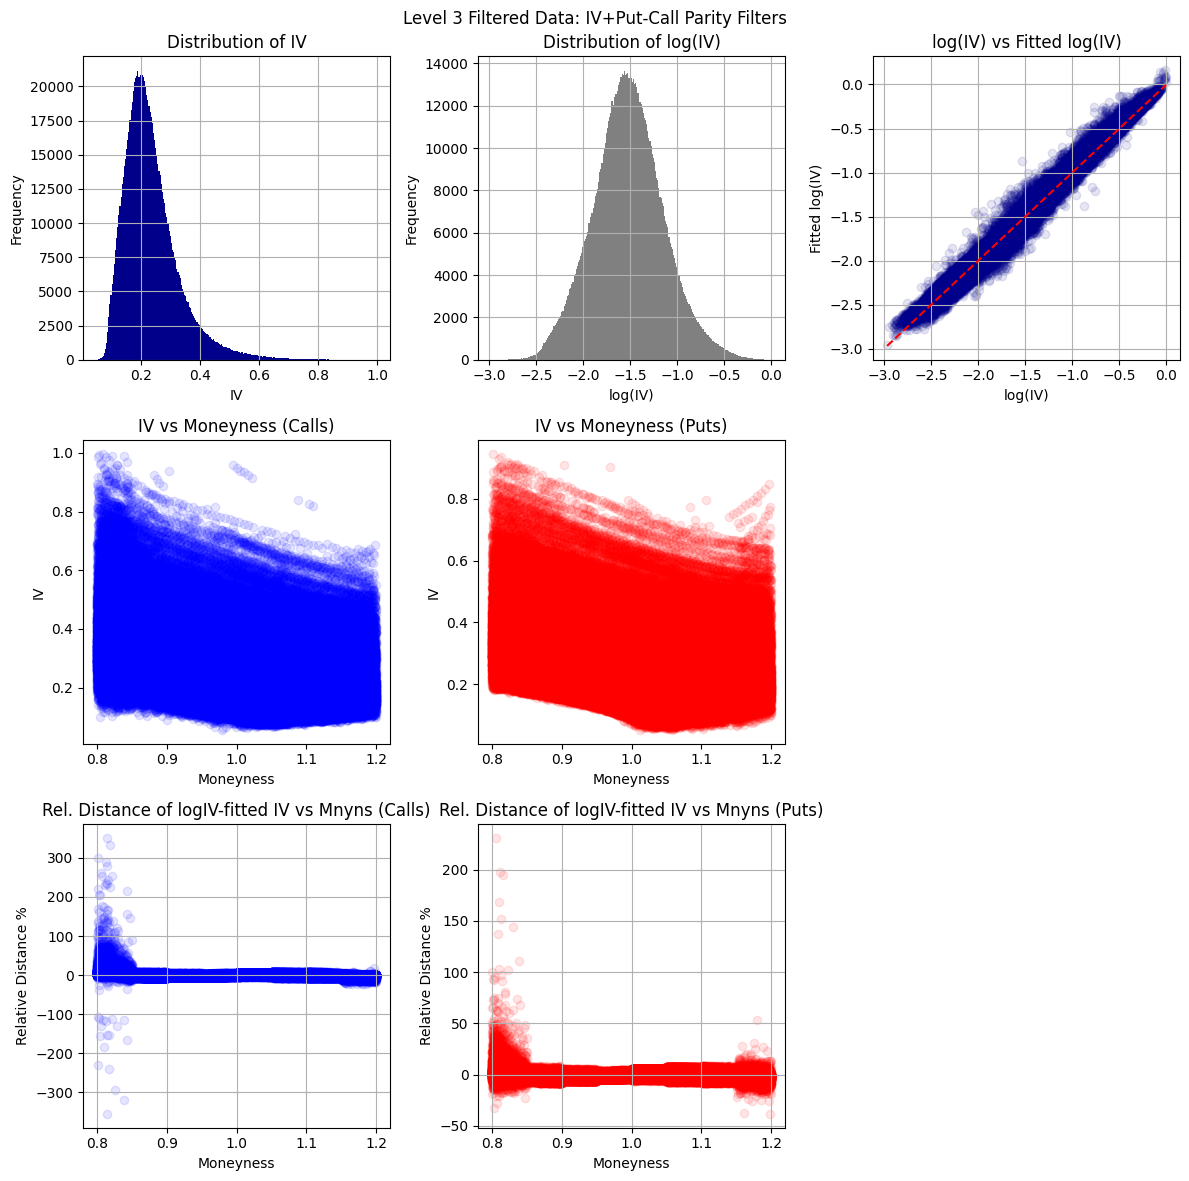

In [31]:
fig, ax = plt.subplots(3,3, figsize=(12,12))

chart_data = l3_filtered_options.reset_index().set_index(['date', 'exdate', 'cp_flag'])

ax[0,0].hist(chart_data['impl_volatility'], bins=250, color='darkblue')
ax[0,0].set_xlabel('IV')
ax[0,0].set_ylabel('Frequency')
ax[0,0].set_title('Distribution of IV')
ax[0,0].grid()

ax[0,1].hist(chart_data['log_iv'], bins=250, color='grey')
ax[0,1].set_xlabel('log(IV)')
ax[0,1].set_ylabel('Frequency')
ax[0,1].set_title('Distribution of log(IV)')
ax[0,1].grid()

# Scatter plot with x=log_iv and y=fitted_iv
ax[0,2].scatter(x=chart_data['log_iv'], y=chart_data['fitted_iv'], color='darkblue', alpha=0.1)
ax[0,2].set_xlabel('log(IV)')
ax[0,2].set_ylabel('Fitted log(IV)')
ax[0,2].set_title('log(IV) vs Fitted log(IV)')
# Add a 45-degree line
ax[0,2].plot([min(chart_data['log_iv']), max(chart_data['log_iv'])], [min(chart_data['log_iv']), max(chart_data['log_iv'])], color='red', linestyle='--')
ax[0,2].grid()


ax[1,0].scatter(x=chart_data.xs('C', level='cp_flag')['mnyns'], y=np.exp(chart_data.xs('C', level='cp_flag')['log_iv']), color='blue', alpha=0.1, label='IV')
ax[1,0].set_xlabel('Moneyness')
ax[1,0].set_ylabel('IV')
ax[1,0].set_title('IV vs Moneyness (Calls)')

ax[1,1].scatter(x=chart_data.xs('P', level='cp_flag')['mnyns'], y=np.exp(chart_data.xs('P', level='cp_flag')['log_iv']), color='red', alpha=0.1, label='IV')
ax[1,1].set_xlabel('Moneyness')
ax[1,1].set_ylabel('IV')
ax[1,1].set_title('IV vs Moneyness (Puts)')


ax[2,0].scatter(x=chart_data.xs('C', level='cp_flag')['mnyns'], y=chart_data.xs('C', level='cp_flag')['rel_distance_iv'], color='blue', alpha=0.1, label='Calls')
ax[2,0].set_xlabel('Moneyness')
ax[2,0].set_ylabel('Relative Distance %')
ax[2,0].set_title('Rel. Distance of logIV-fitted IV vs Mnyns (Calls)')
ax[2,0].grid()

ax[2,1].scatter(x=chart_data.xs('P', level='cp_flag')['mnyns'], y=chart_data.xs('P', level='cp_flag')['rel_distance_iv'], color='red', alpha=0.1, label='Puts')
ax[2,1].set_xlabel('Moneyness')
ax[2,1].set_ylabel('Relative Distance %')
ax[2,1].set_title('Rel. Distance of logIV-fitted IV vs Mnyns (Puts)')
ax[2,1].grid()

# hide unused subplots
ax[1,2].axis('off')
ax[2,2].axis('off')

plt.suptitle('Level 3 Filtered Data: IV+Put-Call Parity Filters')
plt.tight_layout()
plt.show()

## Sensitivity of the Level 3 Filters
- The options deleted at each stage of the Level 3 filters (as described in the paper) are very sensitive to the distance function utilized and the outlier threshold. Below we analyze the sensitivity of the number of options deleted to variation in the distance function (percent distance, Manhattan (absolute) distance, and Euclidean distance), as well as to a range of 2 to 5 standard deviations to drop outliers. 
- Since similar filters are used for the **Implied Volatility Filter** as well as the **Put-Call Parity Filter**, errors in filter construction can have significant downstream effects, as we see in the sensitivity table results below. 

In [32]:
distance_functions = ['percent', 'manhattan', 'euclidean']
outlier_thresholds = [2., 2.5, 3., 3.5, 4., 4.5, 5.] # stdevs

# dataframe to store sensitivity results
pcp_filter_sens = pd.DataFrame(index=pd.MultiIndex.from_product([distance_functions, outlier_thresholds]),
                                      columns=['Deleted', 'Remaining'])
pcp_filter_sens.index.names = ['Rel. Dist. Method', 'Outlier Stdev Thresh.']

iv_filter_sens = pd.DataFrame(index=pd.MultiIndex.from_product([distance_functions, outlier_thresholds]),
                                      columns=['Deleted', 'Remaining'])
iv_filter_sens.index.names = ['Rel. Dist. Method', 'Outlier Stdev Thresh.']

# run sensitivity analysis
for dist in distance_functions:
    for thresh in outlier_thresholds:
        print('Running sensitivity analysis for distance function:', dist, 'and outlier threshold:', thresh)
        l3_data_iv_only = iv_filter_sensitivity(l2_data, dist, thresh)
        iv_filter_sens.loc[(dist, thresh), :] = {'Deleted' : len(l2_data)-len(l3_data_iv_only),
                                                 'Remaining': len(l3_data_iv_only)}
        
        l3_filtered_options = pcp_filter_sensitivity(matched_options, dist, thresh)
        pcp_filter_sens.loc[(dist, thresh), :] = {'Deleted' : len(l3_data_iv_only) - len(l3_filtered_options),
                                                                                 'Remaining': len(l3_filtered_options)}

Running sensitivity analysis for distance function: percent and outlier threshold: 2.0
Running sensitivity analysis for distance function: percent and outlier threshold: 2.5
Running sensitivity analysis for distance function: percent and outlier threshold: 3.0
Running sensitivity analysis for distance function: percent and outlier threshold: 3.5
Running sensitivity analysis for distance function: percent and outlier threshold: 4.0
Running sensitivity analysis for distance function: percent and outlier threshold: 4.5
Running sensitivity analysis for distance function: percent and outlier threshold: 5.0
Running sensitivity analysis for distance function: manhattan and outlier threshold: 2.0
Running sensitivity analysis for distance function: manhattan and outlier threshold: 2.5
Running sensitivity analysis for distance function: manhattan and outlier threshold: 3.0
Running sensitivity analysis for distance function: manhattan and outlier threshold: 3.5
Running sensitivity analysis for di

In [33]:
l3_sens_table = pd.merge(iv_filter_sens, pcp_filter_sens, left_index=True, right_index=True, suffixes=(' - Post-IV', ' - Post-PCP'))
l3_sens_table.style.format('{:,.0f}')
l3_sens_table

Deleted - Post-IV Remaining - Post-IV  \
Rel. Dist. Method Outlier Stdev Thresh.                                         
percent           2.0                               66276             1147509   
                  2.5                               38173             1175612   
                  3.0                               22504             1191281   
                  3.5                               13627             1200158   
                  4.0                                8306             1205479   
                  4.5                                5263             1208522   
                  5.0                                3359             1210426   
manhattan         2.0                              122203             1091582   
                  2.5                               75853             1137932   
                  3.0                               47907             1165878   
                  3.5                               30930             1182855   
                  4.0                               20547             1193238   
                  4.5                               13898             1199887   
                  5.0                                9481             1204304   
euclidean         2.0                              122203             1091582   
                  2.5                               75853             1137932   
                  3.0                               47907             1165878   
                  3.5                               30930             1182855   
                  4.0                               20547             1193238   
                  4.5                               13898             1199887   
                  5.0                                9481             1204304   

                                        Deleted - Post-PCP  \
Rel. Dist. Method Outlier Stdev Thresh.                      
percent           2.0                               144611   
                  2.5                               163072   
                  3.0                               171531   
                  3.5                               173948   
                  4.0                               172889   
                  4.5                               170286   
                  5.0                               167862   
manhattan         2.0                               346738   
                  2.5                               218594   
                  3.0                               162036   
                  3.5                               148221   
                  4.0                               148562   
                  4.5                               151303   
                  5.0                               153632   
euclidean         2.0                               346738   
                  2.5                               218594   
                  3.0                               162036   
                  3.5                               148221   
                  4.0                               148562   
                  4.5                               151303   
                  5.0                               153632   

                                        Remaining - Post-PCP  
Rel. Dist. Method Outlier Stdev Thresh.                       
percent           2.0                                1002898  
                  2.5                                1012540  
                  3.0                                1019750  
                  3.5                                1026210  
                  4.0                                1032590  
                  4.5                                1038236  
                  5.0                                1042564  
manhattan         2.0                                 744844  
                  2.5                                 919338  
                  3.0                                100

In [34]:
error_in_iv_deletions = (l3_sens_table['Deleted - Post-IV'] / check_results.loc[('Level 3 filters', 'IV filter'), 'OptionMetrics']['Deleted'] - 1).to_frame().rename(columns={'Deleted - Post-IV': '% Error in IV Deletions'})
error_in_pcp_deletions = (l3_sens_table['Deleted - Post-PCP'] / check_results.loc[('Level 3 filters', 'Put-call parity filter'), 'OptionMetrics']['Deleted'] - 1).to_frame().rename(columns={'Deleted - Post-PCP': '% Error in PCP Deletions'})
error_in_final_res = (l3_sens_table['Remaining - Post-PCP'] / check_results.loc[('Level 3 filters', 'All'), 'OptionMetrics']['Remaining'] - 1).to_frame().rename(columns={'Remaining - Post-PCP': '% Error Final Option Count'})

error_in_deletions = pd.concat((error_in_iv_deletions, error_in_pcp_deletions, error_in_final_res), axis=1)
display(error_in_deletions.style.format('{:.1%}'))

# Comments on Final Result
- Our final option set seems to distributed in a fairly well-behaved volatility curve, when plotted against moneyness, with a prominent "volatility smirk" for options with moneyness < 1.0. 
- We note that the final option counts from our implementation are mostly within 5% - 10% of Table B1 in the paper, which is surprisingly close, given the number of judgment calls that needed to be made with regard to the filter methodology. 
- This suggests that further efforts to reproduce the paper's results might be challenging, since it is quite likely that the specific composition of options in our final dataset might not correspond exactly with those in the paper, despite our best efforts at reproducing the filters as described. 

---

# Implied Volatilities based on Put-Call Parity Implied Interest Rate
Next we compute implied volatilities based on the put-call parity implied interest rate, and compare them to the T-bill implied volatilities. 

In [ ]:
# TODO